# SSP Tactile Encoding
This demo illuistrates the memorization and replay of spatial tactile perception.

In [15]:
%matplotlib inline

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from skimage.draw import disk, rectangle

from ssp.dynamics import Trajectory
from ssp.maps import Spatial2D
from ssp.models import MLP, Linear
from ssp.plots import create_gif, heatmap_animation
from ssp.utils import converging_trajectory, create_data

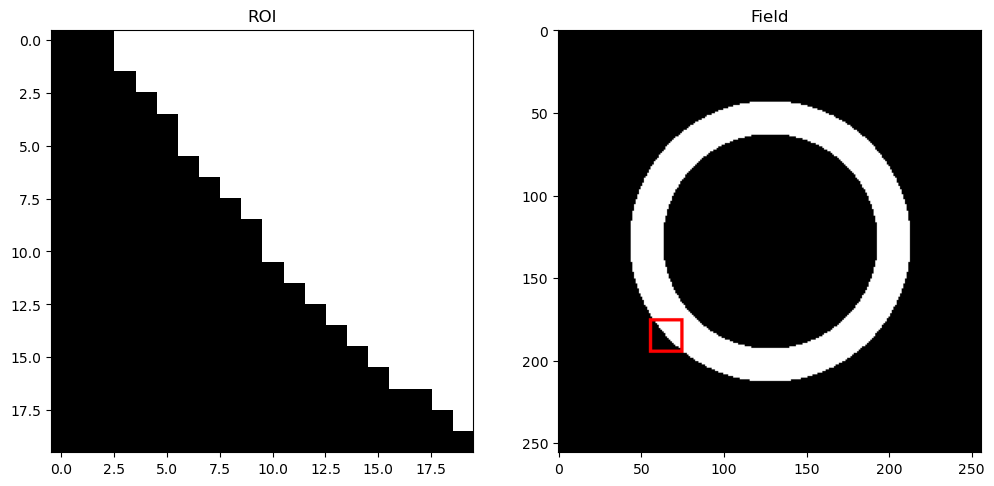

In [69]:
class StimulusGenerator2D:
    def __init__(self, dim=(256,), sample_dim=(20,), profile=("ring", 150, 10)):
        if len(dim) < 2:
            dim = (dim[0], dim[0])
        if len(sample_dim) < 2:
            sample_dim = (sample_dim[0], sample_dim[0])
        self.dim = np.asarray(dim)
        self.sample_dim = np.asarray(sample_dim)
        self.__field = np.zeros((dim[0], dim[1], 3))

        match profile:
            case tuple():
                match profile[0]:
                    case "ring":
                        r0, c0 = disk((dim[1] // 2, dim[0] // 2), np.min(dim) // 3)
                        self.__field[r0, c0] = (1, 1, 1)
                        r1, c1 = disk(
                            (dim[1] // 2, dim[0] // 2), np.min(dim) // 3 - profile[1]
                        )
                        self.__field[r1, c1] = (0, 0, 0)
                    case "square":
                        start = self.dim[:2] // 2 - profile[1] // 2
                        end = start + profile[1]
                        r0, c0 = rectangle(start, end)
                        self.__field[r0, c0] = (1, 1, 1)
                        r1, c1 = rectangle(start + profile[2], end - profile[2])
                        self.__field[r1, c1] = (0, 0, 0)
            case _:
                pass

        self.annotation = {"thickness": 2}

    @property
    def field(self):
        return self.__field

    def sample(self, loc):
        start = np.asarray(loc)
        end = start + self.sample_dim
        # Plots annotation rectangle
        thickness = self.annotation["thickness"]
        annotated = np.copy(self.field)
        r0, c0 = rectangle(np.flip(start), end=np.flip(end), shape=self.field.shape)
        annotated[r0, c0] = (1, 0, 0)
        r1, c1 = rectangle(
            np.flip(start) + thickness,
            end=np.flip(end) - thickness,
            shape=self.field.shape,
        )
        annotated[r1, c1] = self.field[r1, c1]
        return self.field[start[1] : end[1], start[0] : end[0]], annotated


SG2D = StimulusGenerator2D()
sample, annotated = SG2D.sample((55, 175))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(sample)
axs[0].set_title("ROI")
axs[1].imshow(annotated)
axs[1].set_title("Field")
plt.show()

In [28]:
dim = 256
scale = 10

t = 4
dt = 0.05
n_steps = int(t / dt)

x_len = 2
y_len = 2
x_spaces = 101
y_spaces = 101

init_x = 1
init_y = 1

ssp_map = Spatial2D(dim=dim, scale=scale)
ssp_map.build_grid(x_len, y_len, x_spaces, y_spaces)

# define scene trajectories with two objects using differential equations
traj_a = Trajectory(t, dt)
traj_b = Trajectory(t, dt)

names = ["A", "B"]
signs = [-1, 1]

for sign, name in zip(signs, names):
    dxdt = partial(lambda sign, t: sign * np.sin(t * np.pi), sign)
    dydt = partial(lambda sign, t: sign * np.cos(t * np.pi), sign)
    traj_a.add_object_spec(name, 1, 1, dxdt, dydt)

for sign, name in zip(signs, names):
    dxdt = partial(lambda sign, t: sign * np.sin(t * np.pi), sign)
    dydt = partial(lambda sign, t: -1 * sign * np.cos(t * np.pi), sign)
    traj_b.add_object_spec(name, 1, 1, dxdt, dydt)


# generate the dynamics using the method of addition describe above
a_sims = []
ssp = ssp_map.initialize_ssp(traj_a)
cue = ssp_map.initialize_cue(traj_a)

for new_ssp in ssp_map.algebraic_dynamics_gen(traj_a):
    a_sims.append(ssp_map.compute_heatmap(new_ssp * cue))

b_sims = []
ssp = ssp_map.initialize_ssp(traj_b)
cue = ssp_map.initialize_cue(traj_b)

for new_ssp in ssp_map.algebraic_dynamics_gen(traj_b):
    b_sims.append(ssp_map.compute_heatmap(new_ssp * cue))

In [29]:
# plot the results
sims = [a_sims, b_sims]
figsize = (12, 6)

ani = heatmap_animation(sims, figsize)
display(HTML(ani.to_jshtml()))